### Imports

In [1]:
from src.sql_helpers import query_df
from src.panda_helpers import pd, get_unique_sort, sort_dict
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

Connection to SQL server successful!


/home/markus/Desktop/Data Scientist/3. SQL/2. Examinerande_Uppgift/src/sql_helpers.py:19: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


# Task 1

### Get all unique ID's for Category, Subcategory and Product

In [2]:
# Get all unique ProductCategory IDs
category_query = """
SELECT ProductCategoryID, Name
FROM Production.ProductCategory
"""

category_df = query_df(category_query).sort_values("ProductCategoryID").reset_index(drop=True)
productCategoryIDs = get_unique_sort(category_df, "ProductCategoryID")

# Get all unique ProductSubcategory IDs
subcategory_query = """
SELECT ProductSubcategoryID, ProductCategoryID
FROM Production.ProductSubcategory
"""
subcategory_df = query_df(subcategory_query).sort_values("ProductSubcategoryID").reset_index(drop=True)
productSubcategoryIDs = get_unique_sort(subcategory_df, "ProductSubcategoryID")

# Get all unique Product ID's
product_query = """
SELECT ProductID, ProductSubcategoryID
FROM Production.Product
"""

temp = query_df(product_query)
product_df = temp.dropna().sort_values("ProductID").reset_index(drop=True)
productIDs = get_unique_sort(product_df, "ProductID")

# Create dict for all unique ID's
unique_ids = {}
unique_ids["ProductCategoryID"] = list(productCategoryIDs)
unique_ids["ProductSubcategoryID"] = list(productSubcategoryIDs)
unique_ids["ProductID"] = list(productIDs)

### Group all Products to Subcategory

In [3]:
# Create a new DataFrame that contains a list of all product ID's for each Subcategory
# https://stackoverflow.com/questions/22219004/how-to-group-dataframe-rows-into-list-in-pandas-groupby
categorized_products = product_df.groupby("ProductSubcategoryID")["ProductID"].apply(list).reset_index(name="ProductID")
categorized_products["ProductSubcategoryID"] = categorized_products["ProductSubcategoryID"].astype(int)
categorized_products.head()

,ProductSubcategoryID,ProductID
0,1,"[771, 772, 773, 774, 775, 776, 777, 778, 779, ..."
1,2,"[749, 750, 751, 752, 753, 754, 755, 756, 757, ..."
2,3,"[953, 954, 955, 956, 957, 958, 959, 960, 961, ..."
3,4,"[808, 809, 810, 811, 812, 813, 946, 947]"
4,5,"[994, 995, 996]"


### Group all Subcategories to Category

In [4]:
# Create a new DataFrame that contains a list of all Subcategory ID's for each Category
categorized_subcategories = subcategory_df.groupby("ProductCategoryID")["ProductSubcategoryID"].apply(list).reset_index(name="ProductSubcategoryID")
categorized_subcategories.head()

,ProductCategoryID,ProductSubcategoryID
0,1,"[1, 2, 3]"
1,2,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2,3,"[18, 19, 20, 21, 22, 23, 24, 25]"
3,4,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]"


### Expand list of SubcategoryID with the ProductID's

In [5]:
# Join to df1 to get ProductID lists
merged = subcategory_df.merge(categorized_products, on='ProductSubcategoryID', how='left')

# Combine ProductID lists per ProductCategoryID
result = (
    merged
    .groupby('ProductCategoryID')['ProductID']
    .agg(lambda x: [pid for sublist in x for pid in sublist])
    .reset_index()
)

for i in result["ProductCategoryID"]:
    print(f"Category {i} has {len(result["ProductID"].loc[i-1])} unique products.")

Category 1 has 97 unique products.
Category 2 has 134 unique products.
Category 3 has 35 unique products.
Category 4 has 29 unique products.


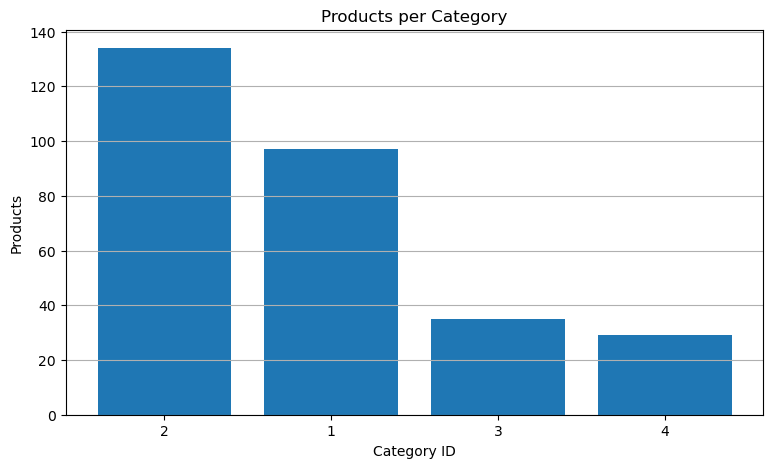

In [6]:
ax, fig = plt.subplots(figsize=(9, 5))

#data = {"A": 7, "B": 4, "C": 9}
#sorted_dict = sort_dict(data)

data = { k:v for (k,v) in zip((str(i) for i in result["ProductCategoryID"]), (len(i) for i in result["ProductID"]))}  
sorted_data = sort_dict(data)

x = [i for i in sorted_data]
y = [sorted_data[i] for i in sorted_data]

plt.bar(x, y)
plt.title("Products per Category")
plt.xlabel("Category ID")
plt.ylabel("Products")
plt.grid(axis="y")
plt.show()

## Conclusion Task 1:
Category 2 has the most products at 134 and Category 4 the least at 29
* Category 1: 97
* Category 2: 134
* Category 3: 35
* Category 4: 29

# Task 2